<a href="https://colab.research.google.com/github/Gonzalo-Ortega/Stereotypical-Behavior-Classification/blob/main/PyTorch_Testing_Gonzalo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:

import matplotlib.pyplot as plt

from torchvision import datasets
from torchvision import transforms
from torchvision import torch

import torch.nn as nn


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
data_path = DATA_PATH = '/content/gdrive/MyDrive/SBC-Gonzalo/PyTorch-CIFAR10'

cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


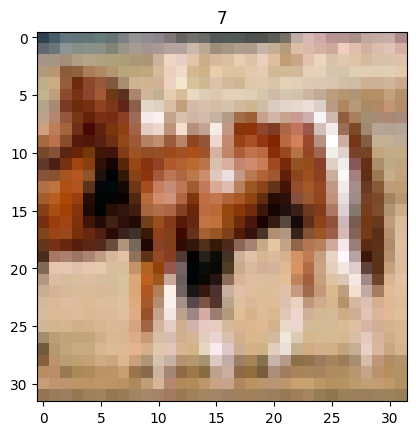

In [52]:
img, label = cifar10[114]
plt.imshow(img)
plt.title(label)
plt.show()

In [27]:
# to_tensor = transforms.ToTensor()
# img_t = to_tensor(img)

# Import the dataset transforming it as a tensor:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                  transform=transforms.ToTensor())

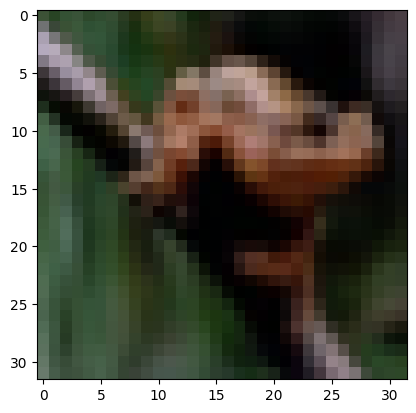

In [29]:
img_t, _ = tensor_cifar10[5000]

# Permute change the order of the axes:
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [32]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [39]:
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                       transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize(imgs.view(3, -1).mean(dim=1),
                                                               imgs.view(3, -1).std(dim=1))
                                       ]))

### 7.2 Distinguishing birds from airplanes

In [66]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]
len(cifar2)

10000

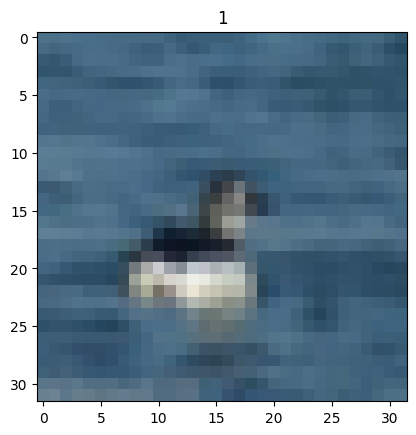

In [63]:
img, label = cifar2[9]
plt.imshow(img)
plt.title(label)
plt.show()

In [68]:
n_out = 2

model = nn.Sequential(
    nn.Linear(
        3072,  # Input features
        512,   # Hiden layer size ⬇️
    ),
    nn.Tanh(),
    nn.Linear(
        512,
        n_out, # Output classes
    )
    )
